# Positional Encoders

In [1]:
from math import e

import numpy as np
import matplotlib.pyplot as plt

0.01 is added to avoid 0 division. To sort of aid in adding possible uniqueness for each encoding, a random value is provided.


In [2]:
def get_rad_list(pos, i, d_model):
  rand_num = np.random.normal(0, 0.1, d_model//2)
  rand_num = [it for x in zip(rand_num, rand_num) for it in x]
  init_angles = np.exp(np.pi)/(((i // 2) + 0.001) * rand_num)
  print(init_angles)
  angle_rates = 1 / np.power(1000, (2 * (i//2)) / np.float32(d_model))
  res = (pos * init_angles ) % (2*np.pi)
  return res

The formula for calculating positional encodings, as described in the Attention Is All You Need paper, makes use of:

*   PE(pos, 2i) = sin(pos / 10000^(2i / d))
*   PE(pos, 2i + 1) = cos(pos / 10000^(2i / d))

This could also, quite possibly, be looked at as:

*   PE(pos, 2i) = sin(omega \* t)
*   PE(pos, 2i + 1) = cos(omega \* t)

Where t is the position (time and position can be seen as quite similar for this case), and omega pertains to the frequency.

In [3]:
def positional_encoding(position, d_model):
  v_pos = np.linspace(0, position, num=d_model)[:, np.newaxis]
  v_dim = np.arange(d_model)[np.newaxis, :]
  rad_list = get_rad_list(v_pos, v_dim, d_model)

  # apply sin() to even
  rad_list[:, 0::2] = np.sin(rad_list[:, 0::2])

  # apply cos() to odd
  rad_list[:, 1::2] = np.cos(rad_list[:, 1::2])

  return rad_list[np.newaxis, ...]

When working with larger dimensions, a pattern appears and seems to largely be in part due to the constriction implaced where the domain is from [0, 2*pi]. This is a stark difference from letting the original geometric progression grow.

[[-1.49181582e+05 -1.49181582e+05 -1.37237840e+02 -1.37237840e+02
   6.90297232e+01  6.90297232e+01 -7.87497159e+01 -7.87497159e+01
   1.29742798e+02  1.29742798e+02  1.02613870e+02  1.02613870e+02
  -9.80375910e+01 -9.80375910e+01 -1.59436813e+01 -1.59436813e+01]]
(1, 16, 16)


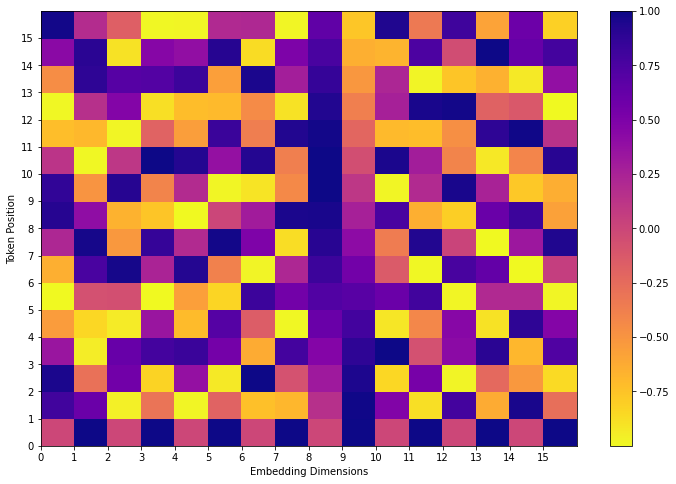

In [4]:
tokens = 16
dimensions = 16

pos_encoding = positional_encoding(tokens, dimensions)
print(pos_encoding.shape)

plt.figure(figsize=(12,8))
plt.pcolormesh(pos_encoding[0], cmap='plasma_r')

plt.xlabel('Embedding Dimensions')
plt.xlim((0, dimensions))
plt.xticks(np.arange(0, dimensions, step=1))

plt.ylabel('Token Position')
plt.ylim((0, tokens))
plt.yticks(np.arange(0, tokens, step=1))

plt.colorbar()
plt.show()

If the functions Bt (B subscript t, where t is the position) are basis vectors, their orthogonality and orthonormality are then checked.

One of the properties of an orthogonal square matrix is that when the matrix and its transpose are multiplied, the resulting matrix should be an identity matrix, that is, if the columns of the matrix are orthonormal.

In [5]:
def check_orthogonal_matrix(matrix):
  # This will throw an error if it's not a square matrix
  assert matrix.shape[1] == matrix.shape[2]

  matrix_res = matrix @ matrix.T

  matrix_id = np.eye(N=matrix.shape[1], M=matrix.shape[2])
  matrix_id = np.expand_dims(matrix_id, 2)

  check_if_res_id_eq = np.all(np.equal(matrix_res, matrix_id))
  # print(f"Is matrix * matrix_transpose = identity? {'Yes' if check_if_res_id_eq else 'No'}")

  matrix_inv = np.linalg.inv(matrix)

  check_if_inv_t_eq = np.all(np.equal(matrix_inv, matrix.T))
  # print(f"Is matrix_inverse = matrix_transpose? {'Yes' if check_if_inv_t_eq else 'No'}")

  return check_if_res_id_eq and check_if_inv_t_eq

In [6]:
print(f"Is the matrix orthogonal? {'Yes' if check_orthogonal_matrix(pos_encoding) else 'No'}")

Is the matrix orthogonal? No


Can check for linear dependence in this manner as well: compute for the eigenvalues and check that there's at least one zero.

In [7]:
pos_sq = np.copy(pos_encoding)
pos_sq = np.squeeze(pos_sq, axis=0)
l, v = np.linalg.eig(pos_sq)
print(f"Is the matrix linearly independent? {'Yes' if len(pos_sq[l == 0, :] == 0) else 'No'}")

Is the matrix linearly independent? No


From the quick check above, it seems that the basis vectors (found in `pos_encoding`) are not orthogonal and orthonormal.

The Gram-Schmidt Process is used to get the orthonormal basis vectors.

Two approaches can be found below. One makes use of a more manual computation, and the other makes use of QR decomposition.

In [8]:
def gs_process(orig_matrix):
  matrix = np.copy(orig_matrix)
  matrix = np.squeeze(matrix, axis=0)

  # This will throw an error if it's not a square matrix
  assert matrix.shape[0] == matrix.shape[1]

  for i in range(1, matrix.shape[1]):
    for j in range(i):
      matrix[:, i] -= np.dot(matrix[:, j], matrix[:, i])/np.dot(matrix[:, j], matrix[:, j]) * matrix[:, j]
    matrix[:, i] /= np.linalg.norm(matrix[:, i])

  return np.expand_dims(matrix, axis=0)

In [9]:
def gs_qr(orig_matrix):
  matrix = np.copy(orig_matrix)
  matrix = np.squeeze(matrix, axis=0)

  # This will throw an error if it's not a square matrix
  assert matrix.shape[0] == matrix.shape[1]

  Q, R = np.linalg.qr(matrix)

  return np.expand_dims(Q, axis=0)

Seen in the graph below are the now orthonormal basis vectors in position encoding.

When trying out a higher valued token and dimension (e.g., 32 x 32 dim), it appears to have some form of lower-valued form of the original positional encoder.

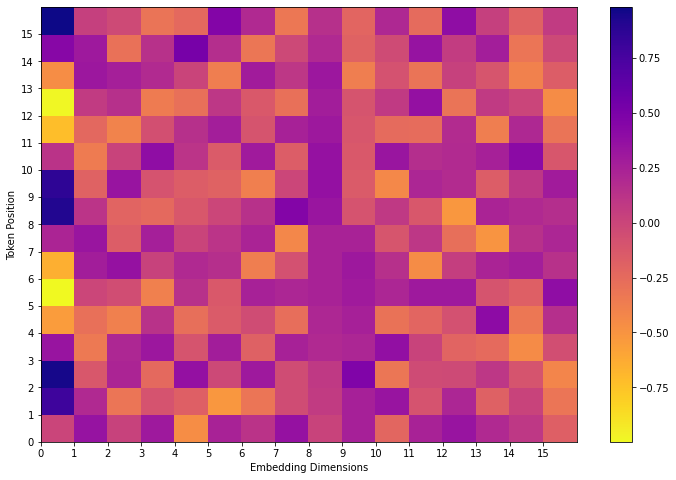

In [10]:
gs_b = gs_process(pos_encoding)

plt.figure(figsize=(12,8))
plt.pcolormesh(gs_b[0], cmap='plasma_r')

plt.xlabel('Embedding Dimensions')
plt.xlim((0, dimensions))
plt.xticks(np.arange(0, dimensions, step=1))

plt.ylabel('Token Position')
plt.ylim((0, tokens))
plt.yticks(np.arange(0, tokens, step=1))

plt.colorbar()
plt.show()